In [22]:
import polars as pl
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN

np.random.seed(123)

In [23]:
numeric_features = [
  "hang_time",
  "seconds_since_hit_085_mlb_person_id_R3",
  "arm_overall_fielder_mlb_person_id",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
]

categorical_features = [
]

responses = [
  "is_out",
]

cols_impute_drop = [
  "hang_time",
  "distance_catch_to_home",
  "distance_traveled_fielder",
  "distance_traveled_all_fielders",
  "distance_to_home_diff",
]

cols_impute_median = [
  "seconds_since_hit_085_mlb_person_id_R3",
  "arm_overall_fielder_mlb_person_id",
]

all_predictors = set(cols_impute_drop + cols_impute_median + categorical_features)
all_columns = set(numeric_features + categorical_features + responses)

In [24]:
# Load in the on base dataset and perform drop imputation
on_base_path = "../data/throw_home_runner_on_third_wide_sprint_arm.parquet"
on_base = pl.scan_parquet(on_base_path)
on_base = on_base.select(all_columns).drop_nulls(cols_impute_drop + responses).collect()

# Split the predictors and the response
X = on_base.select(all_predictors).to_pandas()
y = on_base.select(responses).to_pandas().squeeze()

# Create the train set and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, shuffle=True ,random_state=123)


In [25]:
# Define mini pipelines
numeric_transformer_median = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), 
        ("scaler", StandardScaler())
    ]
)

numeric_transformer_drop = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Apply mini pipelines in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("Numerical Features (Drop)", numeric_transformer_drop,
         cols_impute_drop),
        ("Numerical Features (Median)", numeric_transformer_median,
         cols_impute_median),
        ("Categorical Predictors", categorical_transformer, 
         categorical_features),
    ]
)

# Finalize the pipeline by merging the preprocessing with smote and the model
pipeline = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("adasyn", ADASYN(random_state=123)),
        ("classifier", GradientBoostingClassifier())
    ]
)

# Display the pipeline
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Numerical Features (Drop)',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['hang_time',
                                                   'distance_catch_to_home',
                                                   'distance_traveled_fielder',
                                                   'distance_traveled_all_fielders',
                                                   'distance_to_home_diff']),
                                                 ('Numerical Features (Median)',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['seconds_since_hit_085_mlb_person_id_R3',
                                                   'arm_overall_fielder_mlb_person_id']),
                                                 ('Categorical Predictors',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('adasyn', ADASYN(random_state=123)),
                ('classifier', GradientBoostingClassifier())])

In [26]:
# Train the model
trained_model = pipeline.fit(X_train, y_train)

# Validate the model on a test set
y_pred = trained_model.predict(X_test)

# Print results
print(classification_report(y_test, y_pred))
print("Predictors:\n" + "\n".join(all_predictors))
print("\nResponse:\n" + "\n".join(responses))

              precision    recall  f1-score   support

       False       0.99      0.89      0.93      1438
        True       0.18      0.65      0.28        52

    accuracy                           0.88      1490
   macro avg       0.58      0.77      0.61      1490
weighted avg       0.96      0.88      0.91      1490

Predictors:
hang_time
distance_catch_to_home
distance_traveled_all_fielders
arm_overall_fielder_mlb_person_id
distance_to_home_diff
seconds_since_hit_085_mlb_person_id_R3
distance_traveled_fielder

Response:
is_out


In [41]:
prediction_prob = trained_model.predict_proba(X_test)
prediction_prob_neg = prediction_prob[:, 1]
brier_score = brier_score_loss(y_test, prediction_prob_neg, pos_label=1)

print(brier_score)

0.08045137667624976


Permutation Feature Importance:
                                  Feature  Importance       Std
4                   distance_to_home_diff   -0.040067  0.002719
1                  distance_catch_to_home   -0.024195  0.004495
2          distance_traveled_all_fielders   -0.009631  0.003078
6               distance_traveled_fielder   -0.009060  0.002739
0                               hang_time   -0.007181  0.001815
5  seconds_since_hit_085_mlb_person_id_R3   -0.002819  0.002983
3       arm_overall_fielder_mlb_person_id    0.002148  0.002991


Text(0.5, 0, 'Mean decrease in accuracy')

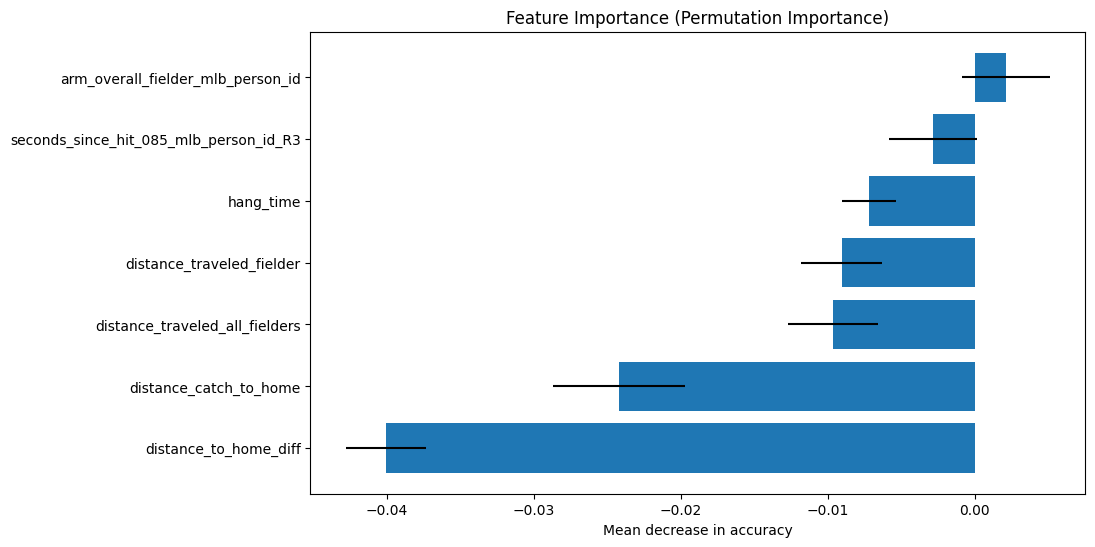

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

# Permutation importance
result = permutation_importance(
    trained_model, X_test, y_test, n_repeats=20, random_state=123, n_jobs=-1
)

# Create a dataframe of feature importance
feature_names = list(all_predictors)
perm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std,
}).sort_values('Importance', ascending=True)

print("Permutation Feature Importance:")
print(perm_importance)

# Plot Permutation Importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance['Feature'], perm_importance['Importance'], 
         xerr=perm_importance['Std'])
plt.title('Feature Importance (Permutation Importance)')
plt.xlabel('Mean decrease in accuracy')